In [1]:
import numpy as np
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment
from gillespy2 import ODECSolver, ODESolver

import matplotlib.pyplot as plt

# devils_v1.0
- Need to validate timespan

In [21]:
class Devilsv101(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="devils_v1.0")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="r", expression="1.2"))
#         self.add_parameter(Parameter(name="K", expression="50000"))
        self.add_parameter(Parameter(name="ds", expression=".0012"))
        self.add_parameter(Parameter(name="dI", expression=".00"))
        self.add_parameter(Parameter(name="L", expression="1.8"))
        # self.add_parameter(Parameter(name="sigma", expression="0.5"))
        # self.add_parameter(Parameter(name="p", expression="0.6"))
        self.add_parameter(Parameter(name="k0", expression=".12"))
        # self.add_parameter(Parameter(name="vf", expression="1"))
        # self.add_parameter(Parameter(name="vt", expression="0"))

        # Variables (initial values adjusted to observed data)
        self.add_species(Species(name="S", initial_value=0, mode="discrete"))
        self.add_species(Species(name="E", initial_value=0, mode="discrete"))
        self.add_species(Species(name="I", initial_value=0, mode="discrete"))
        # self.add_species(Species(name="W", initial_value=0, mode="discrete"))
#         self.add_species(Species(name="R", initial_value=0, mode="discrete"))
        self.add_species(Species(name="Devils", initial_value=0, mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="birth", reactants={}, products={'Devils': 1, 'S': 1}, propensity_function="r*(S+E+I)*(1-(S+E+I)/Devils)"))
        self.add_reaction(Reaction(name="death_S", reactants={'Devils': 1, 'S': 1}, products={}, propensity_function="ds*S"))
        self.add_reaction(Reaction(name="transmission", reactants={'S': 1}, products={'E': 1}, propensity_function="k0*S*I/(S+E+I)"))
        self.add_reaction(Reaction(name="death_E", reactants={'Devils': 1, 'E': 1}, products={}, propensity_function="ds*E"))
        self.add_reaction(Reaction(name="latency", reactants={'E': 1}, products={'I': 1}, propensity_function="E/L"))
        # self.add_reaction(Reaction(name="vaccine_failure", reactants={'W': 1}, products={'E': 1}, propensity_function="k0*sigma*W*I/(S+E+I+W+R)"))
        self.add_reaction(Reaction(name="death_I", reactants={'Devils': 1, 'I': 1}, products={}, propensity_function="dI*I"))
        # self.add_reaction(Reaction(name="death_W", reactants={'W': 1}, products={}, propensity_function="ds*W"))
#         self.add_reaction(Reaction(name="death_R", reactants={'Devils': 1, 'R': 1}, products={}, propensity_function="ds*R"))

        # # Event Triggers
        # vaccination_trig = EventTrigger(expression="t >= vt+vf", initial_value=False, persistent=False)

        # # Event Assignments
        # vaccination_assign_1 = EventAssignment(variable="vt", expression="vt+1")
        # vaccination_assign_2 = EventAssignment(variable="W", expression="W+(S*p)")
        # vaccination_assign_3 = EventAssignment(variable="S", expression="S*(1-p)")

        # # Events
        # self.add_event(Event(name="vaccination", trigger=vaccination_trig, assignments=[vaccination_assign_1, vaccination_assign_2, vaccination_assign_3], delay=None, priority="0", use_values_from_trigger_time=True))

        # Timespan
        self.timespan(np.arange(0, 241, 1)) # month data tspan
#         self.timespan(np.arange(0, 21, 1)) # year data tspan

In [22]:
model = Devilsv101()
print(len(model.tspan))

241


# Simulation Parameters

In [23]:
def configure_simulation():
    solver = ODECSolver(model=model)
    kwargs = {
        "solver":solver,
#         "number_of_trajectories":100,
#         "seed":None,
#         "tau_tol":0.03,
#         "integrator_options":{'rtol': 0.001, 'atol': 1e-06}
    }
    return kwargs

In [24]:
kwargs = configure_simulation()

# Model Inference

In [25]:
%load_ext autoreload
%autoreload 2

from tsfresh.feature_extraction.settings import MinimalFCParameters
from sciope.utilities.priors import uniform_prior
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared
from sciope.inference.abc_inference import ABC
from sciope.inference.rep_smc_abc import ReplenishmentSMCABC
from sklearn.metrics import mean_absolute_error
import dask
from dask.distributed import Client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate some fixed(observed) data based on default parameters of the model

In [26]:
import pandas as pd

pop_data = pd.read_csv('../month_data/total_devil_population_data.csv')
devil_pop = np.array(pop_data['Population'].iloc[:].values)
init_devils_pop = devil_pop[0]
model.listOfSpecies['Devils'].initial_value = init_devils_pop
# model.listOfParameters['K'].initial_value = init_devils_pop

dfdt_data = pd.read_csv('../month_data/DFDT_occupancy_data.csv')
dfdt_concentration = np.array(dfdt_data['Concentration'].iloc[:].values)
dfdt_pop = devil_pop * dfdt_concentration
init_dfdt_pop = dfdt_pop[0]
model.listOfSpecies['I'].initial_value = init_dfdt_pop

r_pop = init_devils_pop - init_dfdt_pop
init_e_pop = 0
init_s_pop = r_pop - init_e_pop
model.listOfSpecies['S'].initial_value = init_s_pop
model.listOfSpecies['E'].initial_value = init_e_pop

obs = np.vstack([devil_pop, dfdt_pop]).reshape(1, 2, -1)
# print(obs)

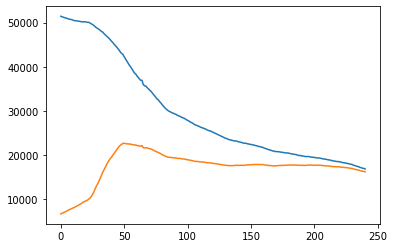

In [27]:
plt.plot(model.tspan, devil_pop)
plt.plot(model.tspan, dfdt_pop)

In [28]:
results = model.run(solver=ODESolver)
results.plotplotly(included_species_list=['Devils', 'I'])

## Define prior distribution

In [29]:
# take default from mode 1 as reference
default_param = np.array(list(model.listOfParameters.items()))[:, 1]

parameter_names = []
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    parameter_names.append(exp.name)

# Set the bounds
bound = np.array(bound)
dmin = bound * 0.5
dmax = bound * 1.5

# Here we use uniform prior
uni_prior = uniform_prior.UniformPrior(dmin, dmax)

## Define simulator

In [30]:
def set_model_parameters(params, model):
    # params - array, need to have the same order as model.listOfParameters
    for e, pname in enumerate(model.listOfParameters.keys()):
        model.get_parameter(pname).set_expression(params[e])
    return model

# Here we use the GillesPy2 Solver
def simulator(params, model):
    model_update = set_model_parameters(params, model)

    res = model_update.run(**kwargs)
#     res = res.to_array()
#     tot_res = np.asarray([x.T for x in res]) # reshape to (N, S, T)
#     # should not contain timepoints
#     tot_res = tot_res[:, 1:, :]
    devils = res['Devils']
    infected = res['I']

    return np.vstack([devils, infected]).reshape(1, 2, -1)
#     return tot_res

# Wrapper, simulator function to abc should should only take one argument (the parameter point)
def simulator2(x):
    return simulator(x, model=model)

## Define summary statistics and distance function

In [31]:
# Function to generate summary statistics
summ_func = auto_tsfresh.SummariesTSFRESH()

# Distance
# ns = naive_squared.NaiveSquaredDistance()

## Start local cluster using dask client

In [32]:
c = Client()

/opt/conda/lib/python3.8/site-packages/distributed/node.py:160: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43975 instead



## Start abc instance

In [33]:
abc = ReplenishmentSMCABC(obs,
                          sim=simulator2,
                          prior_function=uni_prior,
                          summaries_function=summ_func.compute
#                           distance_function=ns
                         )
abc.compute_fixed_mean(1)

In [15]:
# First compute the fixed(observed) mean
# abc.compute_fixed_mean(chunk_size=2)

In [16]:
with dask.config.set(schedular="processes", workers=20):
    print(c)
    res = abc.infer(num_samples=100, batch_size=10, chunk_size=2)

<Client: 'tcp://127.0.0.1:42855' processes=8 threads=64, memory=125.60 GiB>
Tol : 149759695.85315415, R : 9, p_acc : 0.41800000000000004
Tol : 125241973.15153524, R : 13, p_acc : 0.6646666666666667
Tol : 96217618.98301928, R : 22, p_acc : 0.3703333333333333
Tol : 73362438.24172626, R : 44, p_acc : 0.1988235294117647
Tol : 67426749.90110807, R : 36, p_acc : 0.20384615384615387
Tol : 59530811.23410898, R : 70, p_acc : 0.1343333333333333
Tol : 51825550.62883979, R : 119, p_acc : 0.08203669724770643
Tol : 48232492.74283385, R : 254, p_acc : 0.03677049180327869


In [17]:
# mae_inference = mean_absolute_error(bound, abc.results['inferred_parameters'])

## Analysis

In [18]:
posterior = res['accepted_samples']

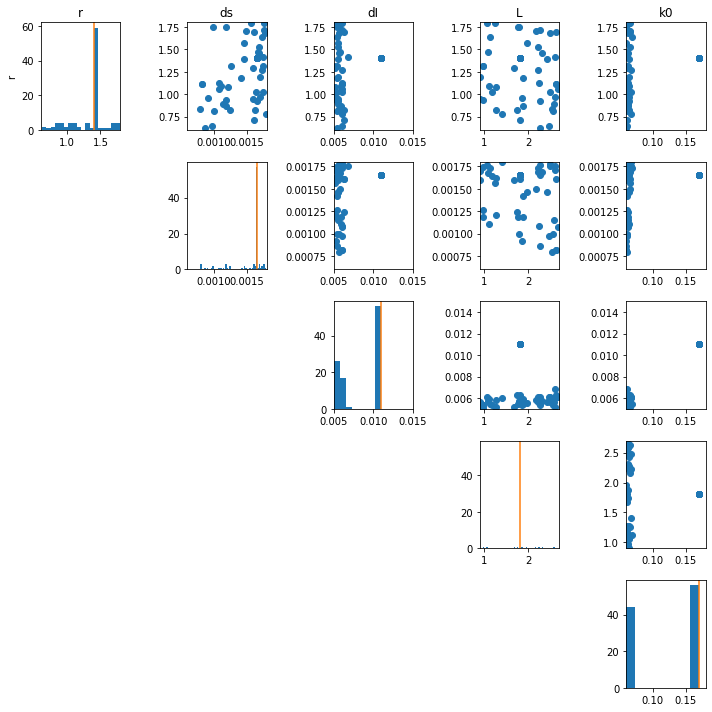

In [19]:
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1])
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                ax[i,j].set_xlim(dmin[i], dmax[i])
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
                ax[i,j].set_ylim(dmin[i], dmax[i])
                ax[i,j].set_xlim(dmin[j], dmax[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(10,10)
fig.tight_layout()

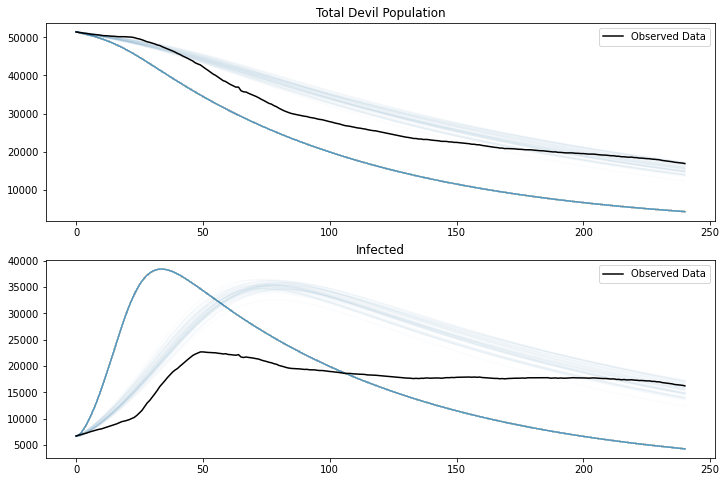

In [20]:
fig, ax = plt.subplots(2)
for i in range(posterior.shape[0]):
    res = simulator2(posterior[i,:])
    ax[0].plot(res[0,0,:], color = 'C0', alpha = 0.02)
    ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
ax[0].plot(obs[0,0,:], color = 'black', label = 'Observed Data')
ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
ax[0].set_title("Total Devil Population")
ax[1].set_title("Infected")
ax[0].legend()
ax[1].legend()
fig.set_size_inches(12, 8)